**IMPORTS**

In [ ]:
from google.colab import drive
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

**UNZIP DATA**

In [ ]:
drive.mount('/content/drive')

! unzip /content/drive/MyDrive/PatternRecognition/CaltechTinySplit.zip -d CaltechTinySplit

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/PatternRecognition/CaltechTinySplit.zip
   creating: CaltechTinySplit/test/accordion/
  inflating: CaltechTinySplit/test/accordion/image_0052.jpg  
  inflating: CaltechTinySplit/test/accordion/image_0053.jpg  
  inflating: CaltechTinySplit/test/accordion/image_0054.jpg  
  inflating: CaltechTinySplit/test/accordion/image_0055.jpg  
   creating: CaltechTinySplit/test/airplanes/
  inflating: CaltechTinySplit/test/airplanes/image_0750.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0761.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0766.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0789.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0790.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0791.jpg  
  inflating: CaltechTinySplit/test/airplanes/image_0792.jpg  
  inflating: CaltechTiny

**READ IMAGE CLASSES**

In [ ]:
os.chdir("/content/CaltechTinySplit")

train_path = 'train'
test_path = 'test'

classes = os.listdir(train_path)

classes

['BACKGROUND_Google',
 'bonsai',
 'barrel',
 'bass',
 'accordion',
 'butterfly',
 'beaver',
 'binocular',
 'camera',
 'brain',
 'ant',
 'buddha',
 'anchor',
 'brontosaurus',
 'airplanes']

**TRAINING DATA PATH HANDLING**

In [ ]:
# STORE FILE PATHS FOR EACH CLASS IN A TRAINING DATASET IN A DICTIONARY
train_files_path = {cls: list(map(lambda x: os.path.join(train_path, cls, x), os.listdir(os.path.join(train_path, cls)))) for cls in classes}

#A LIST OF FILE PATHS FOR EACH CLASS IN THE TRAINING DATASET
train_class_paths = [os.path.join(train_path, cls) for cls in classes]

**STAGE1: READ ALL IMAGES FROM RELATED DIRECTORIES & RESIZE**

In [ ]:
def read_resize_and_convert_to_grayscale_images(image_paths, target_size=(64, 64)):
    resized_grayscale_images = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        img_vector = resized_image.flatten()
        resized_grayscale_images.append(img_vector)
    return np.array(resized_grayscale_images)  # Convert list to numpy array

# Define a function to resize images in the dictionary and convert to grayscale
def resize_and_convert_to_grayscale_images_in_dict(image_dict):
    resized_grayscale_image_dict = {}
    for category, image_paths in image_dict.items():
        resized_grayscale_images = read_resize_and_convert_to_grayscale_images(image_paths)
        resized_grayscale_image_dict[category] = resized_grayscale_images
    return resized_grayscale_image_dict

In [ ]:
resized_images_dict = resize_and_convert_to_grayscale_images_in_dict(train_files_path)

**STAGE2: SELECT EIGENVALUES AND EIGENVECTORS OF PCA**

In [ ]:
def PCA(data):
    # Step 1: Compute covariance matrix for each class data
    covariance_matrices = {}
    # Calculate and store covariance matrices for each class
    for class_name, class_data in data.items():
        covariance_matrices[class_name] = np.cov(class_data, rowvar=True)
    #Step 2: Extract eigenvalues and eigenvectors from covariance matrices
    eigenvalues_dict = {}
    eigenvectors_dict = {}
    # covariance_matrices sözlüğündeki her bir kovaryans matrisine sırayla erişmek
    for class_name, covariance_matrix in covariance_matrices.items():
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        eigenvalues_dict[class_name] = eigenvalues
        eigenvectors_dict[class_name] = eigenvectors

        # Step 3: Sort eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]  # Azalan sırayla sıralanmış indeksler
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Step 4: Select the eigenvectors corresponding to three (3) maximum eigenvalues
        selected_eigenvectors = sorted_eigenvectors[:, :3]

        eigenvalues_dict[class_name] = sorted_eigenvalues[:3]
        eigenvectors_dict[class_name] = selected_eigenvectors

    return eigenvalues_dict, eigenvectors_dict

In [ ]:
# CALL PCA FUNCTION FOR IMPLEMENTING STAGE2 to TRAIN IMAGES
eigenvalues_dict, eigenvectors_dict = PCA(resized_images_dict)

**STAGE3: EXTRACT PCA FEATURES BY USING EIGENVECTORS**

In [ ]:
pca_features_dict = {}
for class_name, class_data in resized_images_dict.items():
    # Eigenvectors matrisini al
    eigenvectors = eigenvectors_dict[class_name]
    # Sınıf matrisini projekte et
    pca_features = np.dot(class_data.T, eigenvectors)
    # Sonuçları sakla
    pca_features_dict[class_name] = pca_features

In [ ]:
# Printing PCA properties for each class
for class_name, pca_features in pca_features_dict.items():
    print(f"The class-{class_name} is represented with {pca_features.shape[0]}x{pca_features.shape[1]} feature matrix")

The class-BACKGROUND_Google is represented with 4096x3 feature matrix
The class-bonsai is represented with 4096x3 feature matrix
The class-barrel is represented with 4096x3 feature matrix
The class-bass is represented with 4096x3 feature matrix
The class-accordion is represented with 4096x3 feature matrix
The class-butterfly is represented with 4096x3 feature matrix
The class-beaver is represented with 4096x3 feature matrix
The class-binocular is represented with 4096x3 feature matrix
The class-camera is represented with 4096x3 feature matrix
The class-brain is represented with 4096x3 feature matrix
The class-ant is represented with 4096x3 feature matrix
The class-buddha is represented with 4096x3 feature matrix
The class-anchor is represented with 4096x3 feature matrix
The class-brontosaurus is represented with 4096x3 feature matrix
The class-airplanes is represented with 4096x3 feature matrix


**STAGE4: TEST AN IMAGE**

In [ ]:
def predict_class(test_image, resized_images_dict, eigenvectors_dict):
    # Combine n times the test vector to match the size of eigenvector matrix
    test_matrix = np.tile(test_image, (len(eigenvectors_dict["barrel"]), 1))

    # Multiply with eigenvector matrix of nx3
    eigenvectors_list = [eigenvectors_dict[class_name] for class_name in resized_images_dict.keys()]
    projected_test_features = np.dot(test_matrix.T, eigenvectors_dict["barrel"])

    # Compute sum of absolute distance between train feature matrix and test feature matrix
    distances = {}
    for class_name, train_features in pca_features_dict.items():
        distance = np.sum(np.abs(train_features - projected_test_features))
        distances[class_name] = distance

    #Show distances between test image and classes
    print("Distances: ",distances)

    # Determine the class label with minimum distance
    min_distance_class = min(distances, key=distances.get)

    return min_distance_class

In [ ]:
#DISPLAY IMAGE FUNCTION
def displayImg(test_image_path):
  img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

***********************************************************************TEST IMAGE 1***********************************************************************


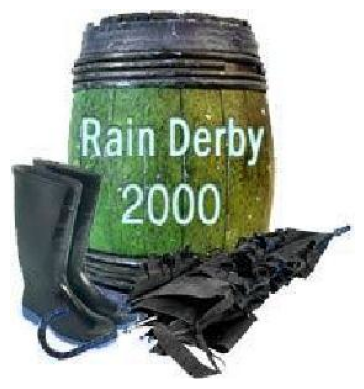

Actual class label: barrel
Distances:  {'BACKGROUND_Google': 5136524.316946652, 'bonsai': 1939004.701256644, 'barrel': 1276884.7516174542, 'bass': 2484571.815753893, 'accordion': 2014705.789781061, 'butterfly': 1801307.2437467456, 'beaver': 3747589.4053630056, 'binocular': 1730322.9097286533, 'camera': 1645059.964391774, 'brain': 2471444.0544874948, 'ant': 4216784.245719423, 'buddha': 3160653.3758813087, 'anchor': 2174026.8240698567, 'brontosaurus': 4257506.737703444, 'airplanes': 1568930.4700859503}
Predicted class label: barrel
***********************************************************************TEST IMAGE 2***********************************************************************


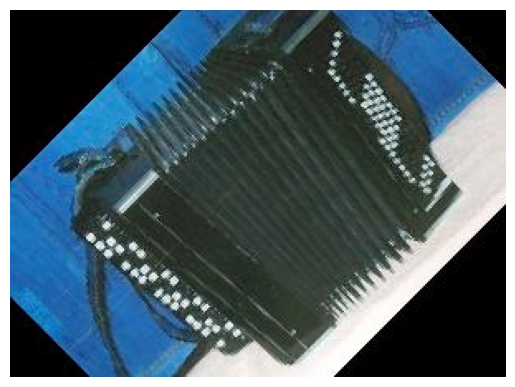

Actual class label: accordion
Distances:  {'BACKGROUND_Google': 4465629.369152078, 'bonsai': 2625304.2674737703, 'barrel': 1619003.2050216193, 'bass': 1993413.6615514788, 'accordion': 1478187.3195396024, 'butterfly': 1795935.2513532578, 'beaver': 3002299.3154914435, 'binocular': 1539273.8291328805, 'camera': 1959198.6620802348, 'brain': 1877144.221489743, 'ant': 3506061.6957596615, 'buddha': 2312128.4431176744, 'anchor': 1615954.1602860591, 'brontosaurus': 3478957.756872419, 'airplanes': 1976170.844288056}
Predicted class label: accordion


In [ ]:
print("***********************************************************************TEST IMAGE 1***********************************************************************")
test_image_path = "/content/CaltechTinySplit/test/barrel/image_0044.jpg"
displayImg(test_image_path)
category = os.path.basename(os.path.dirname(test_image_path))
print("Actual class label:", category)
image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_AREA)
img_vector = resized_image.flatten()
predicted_class = predict_class(img_vector, resized_images_dict, eigenvectors_dict)
print("Predicted class label:", predicted_class)

print("***********************************************************************TEST IMAGE 2***********************************************************************")
test_image_path = "/content/CaltechTinySplit/test/accordion/image_0055.jpg"
displayImg(test_image_path)
category = os.path.basename(os.path.dirname(test_image_path))
print("Actual class label:", category)
image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_AREA)
img_vector = resized_image.flatten()
predicted_class1 = predict_class(img_vector, resized_images_dict, eigenvectors_dict)
print("Predicted class label:", predicted_class1)